## Download the dataset from the following link before using this notebook (Pavia University scene dataset):

##  https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

## Import required libraries

In [1]:
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, SeparableConv2D, Conv2D, Conv2DTranspose, Add,
                                     Activation, BatchNormalization, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim

2025-05-08 17:52:08.365680: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 17:52:08.380112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746715928.396270 3319202 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746715928.401348 3319202 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 17:52:08.418319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

##  Reproducibility Setup ( Set a consistent random seed for NumPy, TensorFlow, and Python's random module to ensure the same results on each run)

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

##  Load the PaviaU Dataset

In [3]:
data = loadmat("PaviaU.mat")
if 'paviaU' not in data:
    raise KeyError("'paviaU' not found in the .mat file.")
hyperspectral_image = data['paviaU'].astype(np.float32)
print("Hyperspectral image shape:", hyperspectral_image.shape)

Hyperspectral image shape: (610, 340, 103)


##  Parameter Initialization for dataset preprocessing only

In [4]:
patch_size = (144, 144)
downscale_factor = 8
nodata_value = -1
group_size = 32
overlap_size = 8
validation_ratio = 0.1
test_coords = (0, 0)  # Fixed test patch top-left corner

## Define Test Patch (the top left)

In [5]:
i0, j0 = test_coords
patch_h, patch_w = patch_size

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


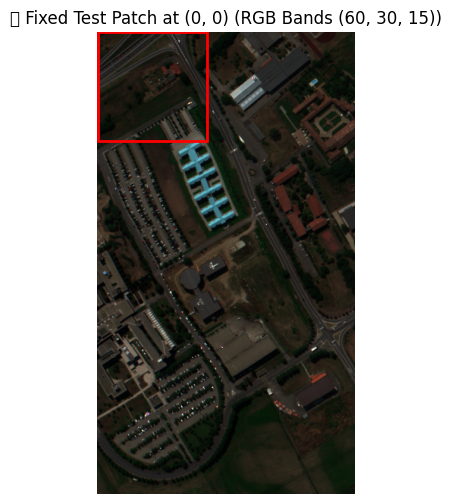

In [6]:
# Define RGB bands for visualization (you can adjust as needed)
rgb_bands = (60, 30, 15)

# Normalize and stack bands
rgb_image = np.stack([hyperspectral_image[..., i] for i in rgb_bands], axis=-1)
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-8)

# Plot with patch overlay
plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.gca().add_patch(plt.Rectangle((j0, i0), patch_w, patch_h, edgecolor='red', facecolor='none', linewidth=2))
plt.title(f"📍 Fixed Test Patch at {test_coords} (RGB Bands {rgb_bands})")
plt.axis('off')
plt.show()

## Extract Patches

In [7]:
def extract_patches(data, patch_size, downscale_factor, nodata_value, test_coords):
    h, w, b = data.shape
    i0, j0 = test_coords

    train_hr, train_lr = [], []
    test_hr, test_lr = None, None

    for i in range(0, h - patch_size[0] + 1, patch_size[0]):
        for j in range(0, w - patch_size[1] + 1, patch_size[1]):
            patch = data[i:i + patch_size[0], j:j + patch_size[1], :]
            if patch.shape[:2] != patch_size or np.any(patch == nodata_value):
                continue
            patch_lr = tf.image.resize(patch,
                                       size=(patch_size[0] // downscale_factor, patch_size[1] // downscale_factor),
                                       method='area').numpy()
            if (i, j) == test_coords:
                test_hr = patch[np.newaxis, ...]
                test_lr = patch_lr[np.newaxis, ...]
            else:
                train_hr.append(patch)
                train_lr.append(patch_lr)

    return (
        np.array(train_hr),
        np.array(train_lr),
        test_hr,
        test_lr
    )

train_hr_full, train_lr_full, test_hr_full, test_lr_full = extract_patches(
    hyperspectral_image, patch_size, downscale_factor, nodata_value, test_coords
)

I0000 00:00:1746715935.471614 3319202 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


## Band grouping 


In [8]:
def apply_band_grouping(patches, group_size, overlap_size):
    grouped = []
    for patch in patches:
        h, w, bands = patch.shape
        step = group_size - overlap_size
        for g in range(0, bands - group_size + 1, step):
            grouped_patch = patch[:, :, g:g + group_size]
            grouped.append(grouped_patch)
    return np.array(grouped)

X_train_hr = apply_band_grouping(train_hr_full, group_size, overlap_size)
X_train_lr = apply_band_grouping(train_lr_full, group_size, overlap_size)
X_test_hr = apply_band_grouping(test_hr_full, group_size, overlap_size)
X_test_lr = apply_band_grouping(test_lr_full, group_size, overlap_size)

## Validation Split FOR train and validation

In [9]:
num_train = X_train_hr.shape[0]
val_size = max(1, int(validation_ratio * num_train))
indices = np.arange(num_train)
np.random.shuffle(indices)
X_train_hr = X_train_hr[indices]
X_train_lr = X_train_lr[indices]
X_validation_hr = X_train_hr[:val_size]
X_validation_lr = X_train_lr[:val_size]
X_train_hr = X_train_hr[val_size:]
X_train_lr = X_train_lr[val_size:]

## Print database sizes to output the number of patches, patch height, width, and band group size for each subset.

In [10]:
print("Hyperspectral image shape:", hyperspectral_image.shape)
print("Train set (HR):", X_train_hr.shape)
print("Train set (LR):", X_train_lr.shape)
print("Validation set (HR):", X_validation_hr.shape)
print("Validation set (LR):", X_validation_lr.shape)
print("Test set (HR):", X_test_hr.shape)
print("Test set (LR):", X_test_lr.shape)

Hyperspectral image shape: (610, 340, 103)
Train set (HR): (19, 144, 144, 32)
Train set (LR): (19, 18, 18, 32)
Validation set (HR): (2, 144, 144, 32)
Validation set (LR): (2, 18, 18, 32)
Test set (HR): (3, 144, 144, 32)
Test set (LR): (3, 18, 18, 32)


##  Model development for Depthwise Separable Dilated Convolutional Network (https://arxiv.org/pdf/2505.00374)

In [11]:
# -----------------------------
# Residual Block (Depthwise Separable)
# -----------------------------
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# -----------------------------
# Dilated Fusion Block
# -----------------------------
def dilated_fusion_block(x, filters):
    d1 = Conv2D(filters, 3, padding='same', dilation_rate=1, activation='relu')(x)
    d2 = Conv2D(filters, 3, padding='same', dilation_rate=2, activation='relu')(x)
    d3 = Conv2D(filters, 3, padding='same', dilation_rate=3, activation='relu')(x)
    fused = Concatenate()([d1, d2, d3])
    fused = Conv2D(filters, 1, padding='same', activation='relu')(fused)
    return fused

# -----------------------------
# Upsample Block (Modular)
# -----------------------------
def upsample_block(x, filters, scale=2, use_residual=False, use_depthwise=True, use_transpose=False):
    shortcut = x  # for optional residual connection

    if use_transpose:
        x = Conv2DTranspose(filters, kernel_size=4, strides=scale, padding='same', activation='relu')(x)
    else:
        x = UpSampling2D(size=(scale, scale), interpolation='bilinear')(x)
        if use_depthwise:
            x = SeparableConv2D(filters, 3, padding='same', activation='relu')(x)
        else:
            x = Conv2D(filters, 3, padding='same', activation='relu')(x)

    if use_residual:
        if shortcut.shape[-1] != filters or shortcut.shape[1] != x.shape[1] or shortcut.shape[2] != x.shape[2]:
            shortcut = Conv2D(filters, 1, padding='same')(UpSampling2D(size=(scale, scale))(shortcut))
        x = Add()([x, shortcut])

    return x

# -----------------------------
# Spectral Angle Mapper (SAM) Loss
# -----------------------------
def spectral_angle_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    dot_product = tf.reduce_sum(y_true * y_pred, axis=-1)
    angle = tf.acos(tf.clip_by_value(dot_product, -1.0, 1.0))
    return tf.reduce_mean(angle)

# -----------------------------
# L2 Loss (Squared Error Sum)
# -----------------------------
def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# -----------------------------
# Combined Loss: MSE + λ₁ × SAM + λ₂ × L2
# -----------------------------
def combined_loss(lambda_sam=0.1, lambda_l2=0.1):
    mse = MeanSquaredError()
    def loss_fn(y_true, y_pred):
        return mse(y_true, y_pred) + lambda_sam * spectral_angle_loss(y_true, y_pred) + lambda_l2 * l2_loss(y_true, y_pred)
    return loss_fn

# -----------------------------
# Super-Resolution Model with Modular Upsampling
# -----------------------------
def build_simple_sr_model(input_shape,
                          use_transpose=True,
                          use_depthwise=True,
                          use_residual=True):
    inputs = Input(shape=input_shape)

    # Initial feature extraction
    x = SeparableConv2D(64, 3, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(3):
        x = residual_block(x, 64)

    # Dilated Fusion Block
    x = dilated_fusion_block(x, 64)

    # Upsample x2 → x4 → x8
    x = upsample_block(x, filters=128, scale=2,
                       use_residual=use_residual,
                       use_depthwise=use_depthwise,
                       use_transpose=use_transpose)
        # Upsample x2 → x4 → x8
    x = upsample_block(x, filters=128, scale=2,
                       use_residual=use_residual,
                       use_depthwise=use_depthwise,
                       use_transpose=use_transpose)
        # Upsample x2 → x4 → x8
    x = upsample_block(x, filters=64, scale=2,
                       use_residual=use_residual,
                       use_depthwise=use_depthwise,
                       use_transpose=use_transpose)
    
    # Final spectral reconstruction
    output = SeparableConv2D(input_shape[-1], 3, padding='same', activation='linear')(x)

    model = Model(inputs, output, name='HSI_SR_Modular_Upsample_Model')
    return model

# -----------------------------
# Model Compilation
# -----------------------------
input_shape = (18, 18, 32)  # Low-resolution input shape (e.g. 1/8 of 144x144)
model = build_simple_sr_model(
    input_shape=input_shape,
    use_transpose=True,         # Toggle between bilinear or transposed
    use_depthwise=True,
    use_residual=True
)

model.compile(
    optimizer='adam',
    loss=combined_loss(lambda_sam=0.3, lambda_l2=0.08),
    metrics=['mse']
)
total_params = model.count_params()
size_in_bytes = total_params * 4  # 4 bytes per float32 param
size_in_mb = size_in_bytes / (1024 ** 2)
print(f"💾 Model size: {size_in_mb:.2f} MB")

#model.summary()

total_params = model.count_params()
params_in_millions = total_params / 1e6
print(f"\n🧠 Total Parameters: {params_in_millions:.2f} Million")

💾 Model size: 2.73 MB

🧠 Total Parameters: 0.72 Million


Epoch 1/1000


2025-05-08 17:52:21.347002: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1746715947.051598 3319255 service.cc:148] XLA service 0x7f75c8044ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746715947.051621 3319255 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7

2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2124406.0000 - mse: 1967042.5000

I0000 00:00:1746715951.902052 3319255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-08 17:52:32.961581: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,11,11]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-05-08 17:52:32.961602: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2025-05-08 17:52:32.961606: W external/local_xl

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2016659.2500 - mse: 1867277.0000  

2025-05-08 17:52:36.204949: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-08 17:52:36.840752: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,11,11]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, 

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 1980397.6250 - mse: 1833701.3750 - val_loss: 1237479.5000 - val_mse: 1145814.1250
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1008843.2500 - mse: 934113.9375 - val_loss: 748590.7500 - val_mse: 693139.5000
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 692262.1875 - mse: 640983.3750 - val_loss: 615868.5625 - val_mse: 570248.5625
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 555391.0000 - mse: 514250.9062 - val_loss: 521426.9062 - val_mse: 482802.6250
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 481724.2812 - mse: 446040.9375 - val_loss: 471092.4375 - val_mse: 436196.6250
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 415733.4688 - mse: 384938.3750 - val_loss: 434309.1250 - val_mse: 402138.0000
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 380197.7188 - mse: 352034.8438 - val_loss: 416617.0000 - val_mse: 385756.4375
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

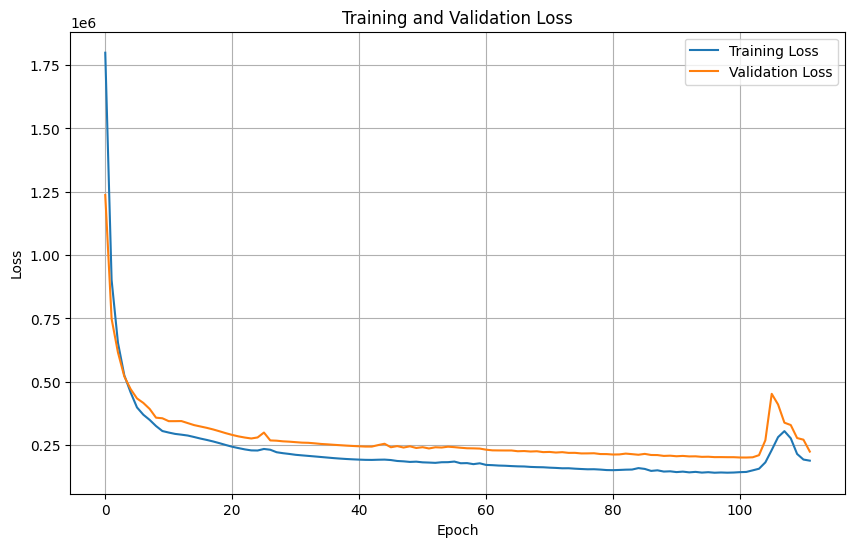

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

##  Save trained model

In [13]:
model.save('PaviaU_8x_saved_model.keras')

## Report the six types of results in terms of PSNR, SSIM, SAM, Correlation Coefficient, ERGAS, and RMSE.

In [14]:
def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images =  model.predict(X_test_lr)

downscale_factor = 8 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

2025-05-08 17:52:55.310252: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-08 17:52:55.807522: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,11,11]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
Average PSNR on the test set: 27.82700354854266
Average SSIM on the test set: 0.61352223
Average SAM on the test set (in degrees): 6.4871725164352645
Average Correlation Coefficient on the test set: 0.8063794741491712
Average ERGAS on the test set: 4.16154859858836
Average RMSE: 0.041044682
